<a href="https://colab.research.google.com/github/camillabocciolone/ll2/blob/main/Stroop_4classes_eegpt_vs_fda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [ ]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [ ]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [ ]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: False


## Clona il repo

In [ ]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [ ]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


In [ ]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["natural", "lowlevel", "midlevel", "highlevel"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    T = X.shape[0]
    t = np.arange(T) / 250.0

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza

    # 1) preprocess leggero a 250 (opzionale, ma ok)
    x = detrend(X, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # 2) resample 250 -> 256
    x = resample_to(x, fs_in, FS_OUT)               # (T256, C)
    t_256 = t[0] + np.arange(x.shape[0]) / FS_OUT   # (T256,)

    # 3) filtri a 256 (coerenti col segnale)
    x = bandpass(x, FS_OUT)
    x = notch50(x, FS_OUT)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t, X[:, ch_idx], '.', alpha=0.4, label="original (250 Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) epoche a 256
    epochs_tc = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * FS_OUT)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_256[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    # 5) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs







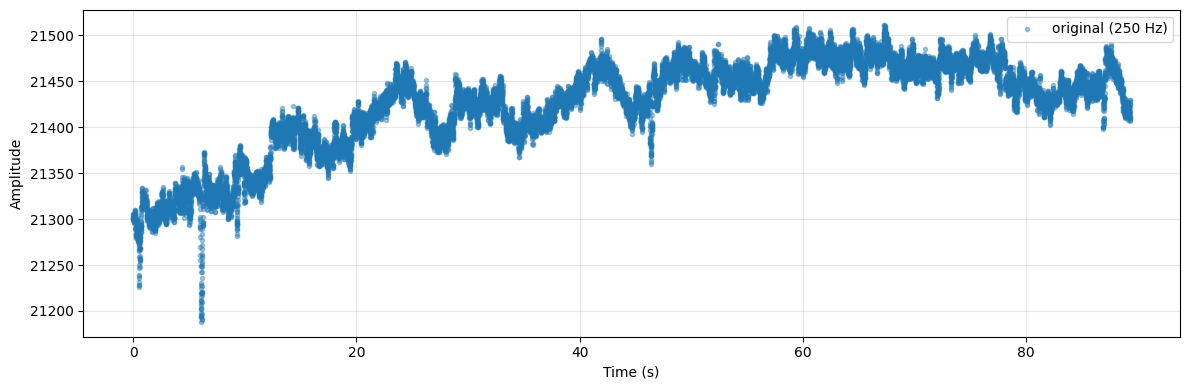

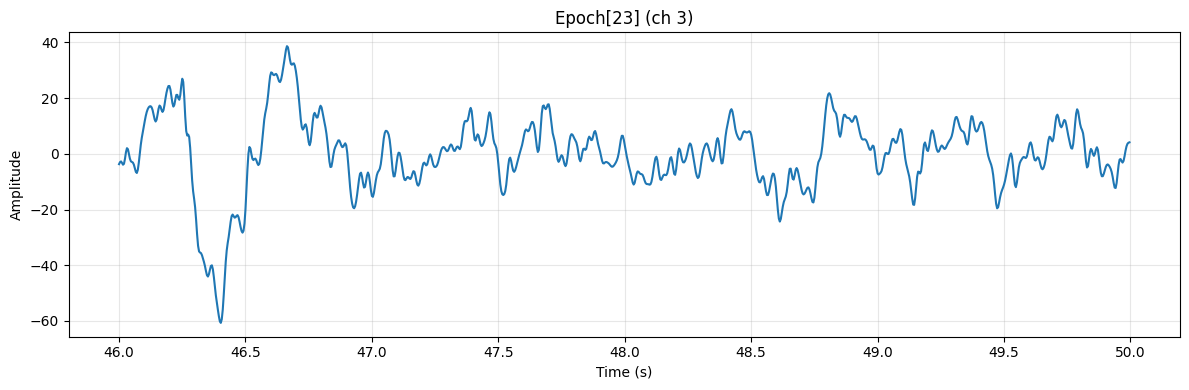

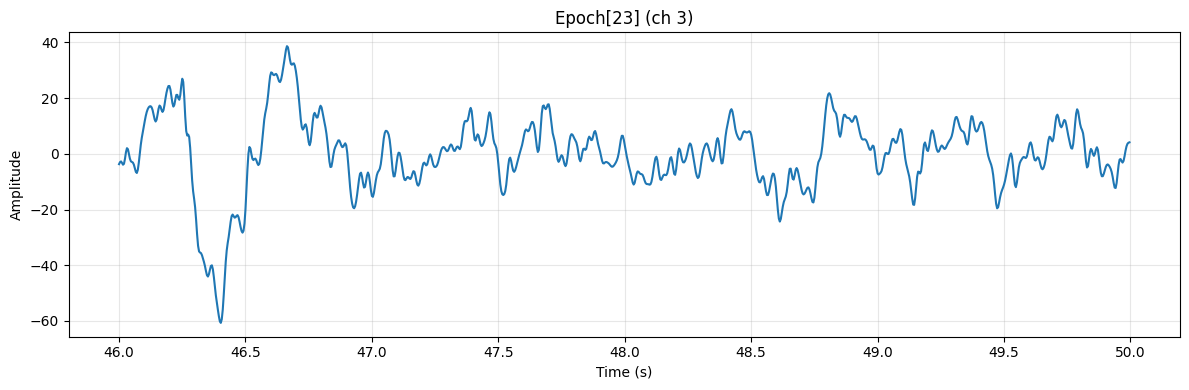

(43, 8, 1024)


In [ ]:
task = "Stroop"
level = "lowlevel"
subject = 8

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

**definiamo build all usando rec_id**

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [ ]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


In [ ]:
X_all = np.asarray(X_all)
y_all = np.asarray(y_all)

meta["rec_id"]  = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
meta["subject"] = np.asarray(meta["subject"]).astype(str).reshape(-1)

assert len(meta["rec_id"])  == len(y_all) == X_all.shape[0]
assert len(meta["subject"]) == len(y_all)


# EEGPT on the true dataset

## recording-level prediction

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [ ]:
print("X_all:", X_all.shape)
print("y_all:", y_all.shape, "meta rec:", meta["rec_id"].shape)
print("unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024)
y_all: (2520,) meta rec: (2520,)
unique rec: 60


In [ ]:
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

rec_ids = np.unique(rec_id_win)
rec_to_subj = {rid: rid.split("|")[-1] for rid in rec_ids}  # oppure costruita da meta
rec_subj = np.array([rec_to_subj[r] for r in rec_ids])

# label per recording: prendi la prima finestra e ASSERTA coerenza
rec_y = []
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0]
    ys = np.unique(y_all[idx])
    assert len(ys) == 1, f"{rid} ha labels diverse: {ys}"
    rec_y.append(int(ys[0]))
rec_y = np.array(rec_y, dtype=np.int64)

subjects = np.unique(rec_subj)  # es. ["S1",...,"S15"]


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

## definizione modello

In [ ]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1) Lista ufficiale dei 58 canali (ordine ESATTO EEGPT 58ch) ---
CHANNELS_58 = [
    'FP1','FPZ','FP2',
    'AF3','AF4',
    'F7','F5','F3','F1','FZ','F2','F4','F6','F8',
    'FT7','FC5','FC3','FC1','FCZ','FC2','FC4','FC6','FT8',
    'T7','C5','C3','C1','CZ','C2','C4','C6','T8',
    'TP7','CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8',
    'P7','P5','P3','P1','PZ','P2','P4','P6','P8',
    'PO7','PO3','POZ','PO4','PO8',
    'O1','OZ','O2'
]
assert len(CHANNELS_58) == 58

# --- 2) I tuoi 8 canali ---
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]

# Mappa: nome_canale -> indice nel vettore 58
idx58 = {ch: i for i, ch in enumerate(CHANNELS_58)}

# Sanity check
for ch in use_channels_8:
    assert ch in idx58, f"Canale {ch} non è nei 58 canali EEGPT"

chan_ids_8 = [idx58[ch] for ch in use_channels_8]
print("8ch:", use_channels_8)
print("chan_ids_8 (posizioni nel 58):", chan_ids_8)

# --- 3) Embedding 8 -> 58 (baseline: zero-fill canali mancanti) ---
def embed_8_to_58(xb_8: torch.Tensor, chan_ids_8: list[int]) -> torch.Tensor:
    """
    xb_8: (B, 8, T) nei canali nell'ordine di use_channels_8
    ritorna: (B, 58, T) nell'ordine CHANNELS_58
    """
    assert xb_8.ndim == 3, "xb_8 deve essere (B,8,T)"
    B, C8, T = xb_8.shape
    assert C8 == 8, f"attesi 8 canali, trovati {C8}"
    xb_58 = torch.zeros((B, 58, T), device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

# --- 4) Estrazione feature EEGPT ---
@torch.no_grad()
def extract_eegpt_features(model, loader, device, chan_ids_8):
    """
    loader deve restituire: xb, yb, rid
    xb: (B,8,T)
    """
    feats_all, y_all_out, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()           # (B,8,T)
        xb58 = embed_8_to_58(xb, chan_ids_8) # (B,58,T)

        feats = model.forward_features(xb58) # (B,D) se così è definito nel tuo EEGPTClassifier
        feats_all.append(feats.detach().cpu())
        y_all_out.append(yb.detach().cpu())

        # rid può essere list/np/torch: normalizziamo a stringhe
        if isinstance(rid, torch.Tensor):
            rid = rid.detach().cpu().numpy()
        rec_all.extend(list(np.asarray(rid).astype(str)))

    return torch.cat(feats_all, 0), torch.cat(y_all_out, 0), np.asarray(rec_all, dtype=str)





Device: cuda
8ch: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
chan_ids_8 (posizioni nel 58): [0, 2, 5, 7, 9, 11, 13, 28]


In [ ]:

# --- Creazione modello EEGPT ---
model = EEGPTClassifier(
    num_classes=4,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=128,
    desired_time_len=1024,
    use_channels_names=CHANNELS_58,   # <-- LISTA CORRETTA
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False

print("Model ready.")




Model ready.


## LOSO

### LogitAdjustedCE

In [ ]:
import sympy, sys
print("sympy version:", getattr(sympy, "__version__", "NO_VERSION"))
print("sympy file:", getattr(sympy, "__file__", "NO_FILE"))
print("sys.path[0]:", sys.path[0])


sympy version: 1.14.0
sympy file: /usr/local/lib/python3.12/dist-packages/sympy/__init__.py
sys.path[0]: /content


In [ ]:
# ============================================================
# EEGPT LOSO (single training on WINDOWS) + recording via log-mean pooling
# - Train ONE classifier per LOSO fold on window embeddings (imbalance-aware LogitAdjustedCE)
# - Window prediction: argmax(logits)
# - Recording prediction: mean(log_softmax(logits)) per rec_id (no second training)
# - t-SNE: optional (windows + pooled recordings) for visualization only
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    accuracy_score
)

# ============================================================
# Utils
# ============================================================

def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def to_str_np(x):
    return np.asarray(to_np(x)).astype(str).reshape(-1)

def recording_pool_logmean_from_logits(logits_np, rec_ids):
    """
    logits_np: (Nwin, C) numpy logits per window
    rec_ids:   (Nwin,)   rec_id per window (str)
    Returns:
      rec_list: (Nrec,)
      rec_pred: (Nrec,)
      rec_logscore: (Nrec, C) mean log-prob for each rec
    """
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)
    logits_np = np.asarray(logits_np)

    uniq = np.unique(rec_ids)
    rec_logscore = []
    for rid in uniq:
        m = (rec_ids == rid)
        L = torch.tensor(logits_np[m], dtype=torch.float32)  # (m, C)
        logp = F.log_softmax(L, dim=1)                       # (m, C)
        agg = logp.mean(dim=0)                               # (C,)
        rec_logscore.append(agg)

    rec_logscore = torch.stack(rec_logscore, dim=0).cpu().numpy()  # (Nrec, C)
    rec_pred = rec_logscore.argmax(axis=1)
    return uniq, rec_pred, rec_logscore

def recording_true_from_windows(y_win, rec_ids, rec_list):
    y_win = np.asarray(y_win).astype(int).reshape(-1)
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)
    y_rec = []
    for rid in rec_list:
        y_rec.append(int(y_win[rec_ids == rid][0]))  # assumes constant label per recording
    return np.asarray(y_rec, dtype=int)

def pool_by_recording_torch(feat, y, rec):
    """
    ONLY for visualization (t-SNE): mean pool embeddings per recording.
    feat: torch (Nwin, D)
    y:    torch (Nwin,)
    rec:  list/np (Nwin,)
    """
    rec = np.asarray(rec).astype(str)
    uniq = np.unique(rec)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec == rid)
        Xr.append(feat[m].mean(dim=0))
        Yr.append(int(y[m][0].item()))
    return torch.stack(Xr, 0), torch.tensor(Yr, dtype=torch.long), uniq

# ============================================================
# MLP classifier
# ============================================================

class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

# ============================================================
# Loss: LogitAdjustedCE
# NOTE: if you already have it defined elsewhere, you can remove this block.
# ============================================================

class LogitAdjustedCE(nn.Module):
    """
    Logit-adjusted cross entropy:
      loss = CE(logits + tau * log(prior), y)
    where prior = counts / sum(counts).
    """
    def __init__(self, counts, tau=1.0, eps=1e-12):
        super().__init__()
        counts = np.asarray(counts, dtype=np.float64)
        prior = counts / max(counts.sum(), 1.0)
        prior = np.clip(prior, eps, 1.0)
        self.register_buffer("adj", torch.tensor(np.log(prior), dtype=torch.float32))
        self.tau = float(tau)

    def forward(self, logits, y):
        return F.cross_entropy(logits + self.tau * self.adj, y)

# ============================================================
# Train ONE classifier on windows (imbalance-aware) with early stopping on val balanced acc
# ============================================================

def train_mlp_with_val(Xtr_np, ytr_np, Xva_np, yva_np, num_classes, device,
                       max_epochs=300, patience=30, lr=1e-3, wd=1e-4, tau=1.0):

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_np, dtype=torch.long).to(device)
    yva = torch.tensor(yva_np, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)

    counts = np.bincount(np.asarray(ytr_np).astype(int), minlength=num_classes)
    crit = LogitAdjustedCE(counts, tau=tau).to(device)
    opt  = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def val_balacc():
        clf.eval()
        pred = clf(Xva).argmax(1).detach().cpu().numpy()
        true = yva.detach().cpu().numpy()
        return balanced_accuracy_score(true, pred)

    best, best_state, noimp = -1, None, 0
    for _ in range(max_epochs):
        clf.train()
        opt.zero_grad(set_to_none=True)
        loss = crit(clf(Xtr), ytr)
        loss.backward()
        opt.step()

        va = val_balacc()
        if va > best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1
            if noimp >= patience:
                break

    if best_state is not None:
        clf.load_state_dict(best_state)
    return clf

# ============================================================
# Dataset
# ============================================================

class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        X_all = np.asarray(X_all)
        y_all = np.asarray(y_all)

        rec_id_all = np.asarray(rec_id_all).astype(str).reshape(-1)
        assert len(rec_id_all) == len(y_all) == X_all.shape[0], \
            f"Mismatch: rec_id={len(rec_id_all)} y={len(y_all)} X={X_all.shape}"

        mask = np.isin(rec_id_all, list(keep_rec_set))
        self.X = X_all[mask]
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        return (torch.tensor(self.X[i], dtype=torch.float32),
                torch.tensor(self.y[i], dtype=torch.long),
                self.r[i])

# ============================================================
# t-SNE sweep utility
# ============================================================

def tsne_sweep(X_np, y_np, title_prefix, perplexities, seeds, pca_dim=30):
    X_np = np.asarray(X_np)
    y_np = np.asarray(y_np).astype(int).reshape(-1)
    assert len(X_np) == len(y_np)

    Xz = StandardScaler().fit_transform(X_np)
    k = min(pca_dim, Xz.shape[1])
    Xp = PCA(n_components=k, random_state=0).fit_transform(Xz)

    for perp in perplexities:
        if perp >= (len(Xp) - 1) / 3:
            continue
        for seed in seeds:
            X2 = TSNE(
                n_components=2,
                perplexity=perp,
                init="pca",
                learning_rate="auto",
                random_state=seed
            ).fit_transform(Xp)

            plt.figure(figsize=(7, 6))
            sc = plt.scatter(X2[:, 0], X2[:, 1], c=y_np, s=55, alpha=0.85)
            plt.colorbar(sc, label="Class")
            plt.title(f"{title_prefix} | perp={perp} | seed={seed}")
            plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
            plt.tight_layout()
            plt.show()

# ============================================================
# MAIN: LOSO
# ============================================================
# REQUIREMENTS you must already have:
# - X_all, y_all
# - meta["rec_id"], meta["subject"]
# - model, chan_ids_8
# - extract_eegpt_features(model, loader, device, chan_ids_8)
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64

rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

rec_ids_all = rec_id_win
subj_all    = subj_win
subjects    = np.unique(subj_all)

num_classes = int(np.max(y_all) + 1)

all_true, all_pred = [], []                 # recording-level
all_true_win, all_pred_win = [], []         # window-level

# t-SNE caches (visualization only)
DO_TSNE = False
DO_WINDOWS_TSNE = True           # se False: solo recording-level
MAX_WIN_TSNE_PER_SUBJ = 500
MAX_REC_TSNE_TOTAL = 1500        # limite globale recording (anti-explosion)

# se True: fai t-SNE su feature scalate (consigliato)
TSNE_USE_SCALED = True

all_Xte_rec, all_yte_rec = [], []
all_Xte_win, all_yte_win = [], []


# Map recording -> subject (using first window of that recording)
rec_ids = np.unique(rec_id_win)
rec_to_subj = {}
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0][0]
    rec_to_subj[rid] = subj_win[idx]

for s in subjects:
    # TEST recordings of subject s
    test_rec = set(np.unique(rec_ids_all[subj_all == s]))

    # TRAINVAL recordings of other subjects
    trainval_rec = np.unique(rec_ids_all[subj_all != s])

    # split train/val recordings grouped by subject
    trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # datasets & loaders (WINDOW level)
    train_ds = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
    val_ds   = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
    test_ds  = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    # Extract EEGPT window embeddings
    tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    # ------------------------------------------------------------
    # SINGLE TRAINING on WINDOWS + RECORDING via log-mean pooling
    # ------------------------------------------------------------
    Xtr_w = to_np(tr_feat)
    Xva_w = to_np(va_feat)
    Xte_w = to_np(te_feat)

    ytr_w = to_np(tr_y).astype(int)
    yva_w = to_np(va_y).astype(int)
    yte_w = to_np(te_y).astype(int)

    # scale windows (fit train only)
    scaler_w = StandardScaler()
    Xtr_w_np = scaler_w.fit_transform(Xtr_w)
    Xva_w_np = scaler_w.transform(Xva_w)
    Xte_w_np = scaler_w.transform(Xte_w)


    # train ONE clf on windows (imbalance-aware)
    clf = train_mlp_with_val(
        Xtr_w_np, ytr_w,
        Xva_w_np, yva_w,
        num_classes=num_classes,
        device=device,
        tau=1.0
    )

    # test logits + window preds
    with torch.no_grad():
        clf.eval()
        Xte_t = torch.tensor(Xte_w_np, dtype=torch.float32).to(device)
        logits_te_t = clf(Xte_t)  # (Nwin_te, C)

    logits_te = logits_te_t.detach().cpu().numpy()
    pred_win  = logits_te.argmax(axis=1)

    all_true_win.extend(yte_w.tolist())
    all_pred_win.extend(pred_win.tolist())

    # recording preds via correct pooling (NO retrain)
    rec_list, pred_rec, _ = recording_pool_logmean_from_logits(logits_te, te_rec)
    true_rec = recording_true_from_windows(yte_w, te_rec, rec_list)

    all_true.extend(true_rec.tolist())
    all_pred.extend(pred_rec.tolist())

    # ------------------------------------------------------------
    # t-SNE caches (visualization only)
    # ------------------------------------------------------------
    # recording points: mean-pooled embeddings per rec (for plotting only)
    # ------------------------------------------------------------
    # t-SNE caches (visualization only)
    # ------------------------------------------------------------
    if DO_TSNE:
        # scegli se cachare scaled o raw (scaled consigliato)
        Xte_for_tsne = Xte_w_np if TSNE_USE_SCALED else Xte_w
        yte_for_tsne = yte_w

        # recording points: mean-pooled embeddings per rec (per plotting only)
        # NB: qui usiamo mean-pool sulle FEATURES (non sui logits), solo per viz.
        X_te_rec_vis, y_te_rec_vis, _ = pool_by_recording_torch(
            torch.tensor(Xte_for_tsne, dtype=torch.float32),
            torch.tensor(yte_for_tsne, dtype=torch.long),
            te_rec
        )
        all_Xte_rec.append(to_np(X_te_rec_vis))
        all_yte_rec.append(to_np(y_te_rec_vis))

        # window points: subsample embeddings per subject (for plotting only)
        if DO_WINDOWS_TSNE:
            Xw = Xte_for_tsne
            yw = yte_for_tsne
            if len(Xw) > MAX_WIN_TSNE_PER_SUBJ:
                rs = np.random.RandomState(0)
                idx = rs.choice(len(Xw), size=MAX_WIN_TSNE_PER_SUBJ, replace=False)
                Xw = Xw[idx]
                yw = yw[idx]
            all_Xte_win.append(Xw)
            all_yte_win.append(yw)


# ============================================================
# FINAL REPORTS
# ============================================================

print("\n==============================")
print("LOSO RECORDING-LEVEL (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(all_true, all_pred, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true, all_pred))
print("Accuracy:", accuracy_score(all_true, all_pred))

print("\n==============================")
print("LOSO WINDOW-LEVEL")
print("==============================")
cm_w = confusion_matrix(all_true_win, all_pred_win, labels=list(range(num_classes)))
print("Confusion matrix:\n", cm_w)
print("\nReport:\n", classification_report(all_true_win, all_pred_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_win, all_pred_win))
print("Accuracy:", accuracy_score(all_true_win, all_pred_win))

# ============================================================
# FINAL t-SNE (optional)
# ============================================================

# ============================================================
# FINAL t-SNE (optional)
# ============================================================
if DO_TSNE:
    # recording-level t-SNE (pooled embeddings, TEST points)
    if len(all_Xte_rec) > 0:
        X_tsne_rec = np.concatenate(all_Xte_rec, axis=0)
        y_tsne_rec = np.concatenate(all_yte_rec, axis=0)

        # subsample globale recording (se troppi)
        if len(X_tsne_rec) > MAX_REC_TSNE_TOTAL:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(X_tsne_rec), size=MAX_REC_TSNE_TOTAL, replace=False)
            X_tsne_rec = X_tsne_rec[idx]
            y_tsne_rec = y_tsne_rec[idx]

        if len(X_tsne_rec) >= 10:  # guardia
            tsne_sweep(
                X_tsne_rec, y_tsne_rec,
                title_prefix="LOSO t-SNE (RECORDING features mean-pooled, TEST points)",
                perplexities=(5, 8, 10, 12, 15),
                seeds=(0, 1, 2, 3),
                pca_dim=30
            )

    # windows t-SNE (TEST windows across all LOSO iters)
    if DO_WINDOWS_TSNE and len(all_Xte_win) > 0:
        X_tsne_win = np.concatenate(all_Xte_win, axis=0)
        y_tsne_win = np.concatenate(all_yte_win, axis=0)

        if len(X_tsne_win) >= 50:  # guardia
            tsne_sweep(
                X_tsne_win, y_tsne_win,
                title_prefix="LOSO t-SNE (WINDOW features, TEST windows)",
                perplexities=(10, 15, 20, 30, 40),
                seeds=(0, 1, 2),
                pca_dim=30
            )




LOSO RECORDING-LEVEL (log-mean pooled logits)
Confusion matrix:
 [[11  3  0  1]
 [ 1  4  3  7]
 [ 1  5  4  5]
 [ 2  3  2  8]]

Report:
               precision    recall  f1-score   support

           0      0.733     0.733     0.733        15
           1      0.267     0.267     0.267        15
           2      0.444     0.267     0.333        15
           3      0.381     0.533     0.444        15

    accuracy                          0.450        60
   macro avg      0.456     0.450     0.444        60
weighted avg      0.456     0.450     0.444        60

Balanced Accuracy: 0.44999999999999996
Accuracy: 0.45

LOSO WINDOW-LEVEL
Confusion matrix:
 [[423 132 135 145]
 [ 84 120 119 159]
 [ 80 120 103 156]
 [109 200 165 270]]

Report:
               precision    recall  f1-score   support

           0      0.608     0.507     0.553       835
           1      0.210     0.249     0.228       482
           2      0.197     0.224     0.210       459
           3      0.370     0.36

In [ ]:
# ============================================================
# ROBUSTNESS (4-class): LOW-DATA SWEEP (LOSO)
# - Subsample SOLO TRAIN windows (stratificato per classe)
# - Val e Test completi
# - Metriche: window-level + recording-level (log-mean pooling)
# ============================================================

import pandas as pd
from torch.utils.data import Subset
from sklearn.metrics import f1_score

ROBUST_FRACS = [1.0, 0.75, 0.5, 0.25, 0.10]
ROBUST_SEEDS = [0, 1, 2]

def stratified_subsample_indices(y, frac, rng):
    y = np.asarray(y).astype(int).reshape(-1)
    n = len(y)
    if frac >= 1.0 or n == 0:
        return np.arange(n)

    idx_all = np.arange(n)
    idx_keep = []
    for c in np.unique(y):
        cls_idx = idx_all[y == c]
        if len(cls_idx) == 0:
            continue
        k = int(np.round(frac * len(cls_idx)))
        k = max(1, min(k, len(cls_idx)))
        idx_keep.append(rng.choice(cls_idx, size=k, replace=False))

    idx_keep = np.concatenate(idx_keep) if len(idx_keep) else np.array([], dtype=int)
    rng.shuffle(idx_keep)
    return idx_keep

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    return {
        "acc":  accuracy_score(y_true, y_pred),
        "bacc": balanced_accuracy_score(y_true, y_pred),
        "f1m":  f1_score(y_true, y_pred, average="macro"),
    }

def run_loso_eegpt_robust(frac, seed):
    rng = np.random.RandomState(seed)

    rec_ids_all = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
    subj_all    = np.asarray(meta["subject"]).astype(str).reshape(-1)
    y_all_np    = np.asarray(y_all).astype(int).reshape(-1)

    subjects = np.unique(subj_all)
    num_classes = int(y_all_np.max() + 1)
    assert num_classes == 4, f"Attenzione: num_classes={num_classes}, ma questo sweep è per 4 classi."

    # rec -> subj
    uniq_rec = np.unique(rec_ids_all)
    rec_to_subj = {}
    for rid in uniq_rec:
        idx0 = np.where(rec_ids_all == rid)[0][0]
        rec_to_subj[rid] = subj_all[idx0]

    rows = []

    all_true_win, all_pred_win = [], []
    all_true_rec, all_pred_rec = [], []

    for s_test in subjects:
        test_rec = set(np.unique(rec_ids_all[subj_all == s_test]))

        trainval_rec = np.unique(rec_ids_all[subj_all != s_test])
        trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
        train_rec = set(trainval_rec[tr_idx])
        val_rec   = set(trainval_rec[va_idx])

        train_ds_full = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
        val_ds        = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
        test_ds       = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

        # subsample TRAIN windows
        keep_idx = stratified_subsample_indices(train_ds_full.y, frac, rng)
        train_ds = Subset(train_ds_full, keep_idx)

        train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
        val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
        test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

        tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
        va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
        te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

        Xtr = to_np(tr_feat); ytr = to_np(tr_y).astype(int)
        Xva = to_np(va_feat); yva = to_np(va_y).astype(int)
        Xte = to_np(te_feat); yte = to_np(te_y).astype(int)

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xva = scaler.transform(Xva)
        Xte = scaler.transform(Xte)

        clf = train_mlp_with_val(Xtr, ytr, Xva, yva, num_classes=num_classes, device=device, tau=1.0)

        with torch.no_grad():
            clf.eval()
            logits = clf(torch.tensor(Xte, dtype=torch.float32).to(device)).detach().cpu().numpy()

        pred_win = logits.argmax(axis=1)
        all_true_win.extend(yte.tolist())
        all_pred_win.extend(pred_win.tolist())

        rec_list, pred_rec, _ = recording_pool_logmean_from_logits(logits, te_rec)
        true_rec = recording_true_from_windows(yte, te_rec, rec_list)

        all_true_rec.extend(true_rec.tolist())
        all_pred_rec.extend(pred_rec.tolist())

        mW = compute_metrics(yte, pred_win)
        mR = compute_metrics(true_rec, pred_rec)

        rows.append({
            "seed": seed,
            "frac": frac,
            "test_subject": s_test,
            "n_train_full": len(train_ds_full),
            "n_train_used": len(keep_idx),
            "win_bacc": mW["bacc"],
            "rec_bacc": mR["bacc"],
            "win_acc":  mW["acc"],
            "rec_acc":  mR["acc"],
            "win_f1m":  mW["f1m"],
            "rec_f1m":  mR["f1m"],
        })

    # GLOBAL row
    gW = compute_metrics(all_true_win, all_pred_win)
    gR = compute_metrics(all_true_rec, all_pred_rec)
    rows.append({
        "seed": seed,
        "frac": frac,
        "test_subject": "GLOBAL",
        "n_train_full": np.nan,
        "n_train_used": np.nan,
        "win_bacc": gW["bacc"],
        "rec_bacc": gR["bacc"],
        "win_acc":  gW["acc"],
        "rec_acc":  gR["acc"],
        "win_f1m":  gW["f1m"],
        "rec_f1m":  gR["f1m"],
    })

    return pd.DataFrame(rows)



In [ ]:
# ============================================================
# EEGPT ROBUSTNESS SPEEDUP: cache embeddings per LOSO fold
# ============================================================

import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

def build_eegpt_fold_cache(X_all, y_all, meta, model, chan_ids_8, device, BATCH=64):
    rec_ids_all = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
    subj_all    = np.asarray(meta["subject"]).astype(str).reshape(-1)
    y_all_np    = np.asarray(y_all).astype(int).reshape(-1)

    subjects = np.unique(subj_all)
    num_classes = int(y_all_np.max() + 1)

    # rec -> subj (prima finestra)
    uniq_rec = np.unique(rec_ids_all)
    rec_to_subj = {}
    for rid in uniq_rec:
        idx0 = np.where(rec_ids_all == rid)[0][0]
        rec_to_subj[rid] = subj_all[idx0]

    cache = {}
    for s_test in subjects:
        test_rec = set(np.unique(rec_ids_all[subj_all == s_test]))

        trainval_rec = np.unique(rec_ids_all[subj_all != s_test])
        trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
        train_rec = set(trainval_rec[tr_idx])
        val_rec   = set(trainval_rec[va_idx])

        # window datasets
        train_ds_full = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
        val_ds        = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
        test_ds       = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

        train_loader = DataLoader(train_ds_full, batch_size=BATCH, shuffle=False)
        val_loader   = DataLoader(val_ds,       batch_size=BATCH, shuffle=False)
        test_loader  = DataLoader(test_ds,      batch_size=BATCH, shuffle=False)

        # extract embeddings ONCE
        tr_feat, tr_y, tr_r = extract_eegpt_features(model, train_loader, device, chan_ids_8)
        va_feat, va_y, va_r = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
        te_feat, te_y, te_r = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

        cache[s_test] = {
            "Xtr_full": to_np(tr_feat),
            "ytr_full": to_np(tr_y).astype(int),
            "Xva":      to_np(va_feat),
            "yva":      to_np(va_y).astype(int),
            "Xte":      to_np(te_feat),
            "yte":      to_np(te_y).astype(int),
            "te_rec":   np.asarray(to_np(te_r)).astype(str),   # rec id per finestra test
        }

        print(f"[cache] subj={s_test} | Xtr={cache[s_test]['Xtr_full'].shape} "
              f"Xva={cache[s_test]['Xva'].shape} Xte={cache[s_test]['Xte'].shape}")

    return cache, num_classes

# ---- build once
fold_cache, num_classes = build_eegpt_fold_cache(X_all, y_all, meta, model, chan_ids_8, device, BATCH=BATCH)
print("Done. Cached folds:", len(fold_cache), "| num_classes:", num_classes)


[cache] subj=S1 | Xtr=(1867, 512) Xva=(479, 512) Xte=(174, 512)
[cache] subj=S10 | Xtr=(1867, 512) Xva=(495, 512) Xte=(158, 512)
[cache] subj=S11 | Xtr=(1846, 512) Xva=(495, 512) Xte=(179, 512)
[cache] subj=S12 | Xtr=(1859, 512) Xva=(495, 512) Xte=(166, 512)
[cache] subj=S13 | Xtr=(1871, 512) Xva=(495, 512) Xte=(154, 512)
[cache] subj=S14 | Xtr=(1888, 512) Xva=(495, 512) Xte=(137, 512)
[cache] subj=S15 | Xtr=(1869, 512) Xva=(495, 512) Xte=(156, 512)
[cache] subj=S2 | Xtr=(1800, 512) Xva=(495, 512) Xte=(225, 512)
[cache] subj=S3 | Xtr=(1872, 512) Xva=(495, 512) Xte=(153, 512)
[cache] subj=S4 | Xtr=(1899, 512) Xva=(495, 512) Xte=(126, 512)
[cache] subj=S5 | Xtr=(1899, 512) Xva=(446, 512) Xte=(175, 512)
[cache] subj=S6 | Xtr=(1929, 512) Xva=(446, 512) Xte=(145, 512)
[cache] subj=S7 | Xtr=(1929, 512) Xva=(445, 512) Xte=(146, 512)
[cache] subj=S8 | Xtr=(1878, 512) Xva=(445, 512) Xte=(197, 512)
[cache] subj=S9 | Xtr=(1846, 512) Xva=(445, 512) Xte=(229, 512)
Done. Cached folds: 15 | num_class

In [ ]:
import random, torch

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    return {
        "acc":  accuracy_score(y_true, y_pred),
        "bacc": balanced_accuracy_score(y_true, y_pred),
        "f1m":  f1_score(y_true, y_pred, average="macro"),
    }

def run_eegpt_robust_cached(fold_cache, frac, seed, num_classes,
                           max_epochs=120, patience=12, tau=1.0):
    rng = np.random.RandomState(seed)

    all_true_win, all_pred_win = [], []
    all_true_rec, all_pred_rec = [], []

    rows = []

    for s_test, d in fold_cache.items():
        Xtr_full = d["Xtr_full"]; ytr_full = d["ytr_full"]
        Xva      = d["Xva"];      yva      = d["yva"]
        Xte      = d["Xte"];      yte      = d["yte"]
        te_rec   = d["te_rec"]

        # subsample SOLO TRAIN windows (stratificato) — riusa la tua funzione se già definita
        keep_idx = stratified_subsample_indices(ytr_full, frac, rng)

        Xtr = Xtr_full[keep_idx]
        ytr = ytr_full[keep_idx]

        # scaler fit solo su train subsampled
        sc = StandardScaler()
        Xtr = sc.fit_transform(Xtr)
        Xva_s = sc.transform(Xva)
        Xte_s = sc.transform(Xte)

        set_all_seeds(10000*seed + (abs(hash(str(s_test))) % 10000))

        # train MLP downstream (più veloce: meno epochs/patience)
        clf = train_mlp_with_val(
            Xtr, ytr,
            Xva_s, yva,
            num_classes=num_classes,
            device=device,
            tau=tau,
            max_epochs=max_epochs,
            patience=patience
        )

        # test logits su windows
        with torch.no_grad():
            clf.eval()
            logits_te = clf(torch.tensor(Xte_s, dtype=torch.float32).to(device)).detach().cpu().numpy()

        pred_win = logits_te.argmax(axis=1)

        all_true_win.extend(yte.tolist())
        all_pred_win.extend(pred_win.tolist())

        # recording pooling (log-mean) — usa le tue funzioni
        rec_list, pred_rec, _ = recording_pool_logmean_from_logits(logits_te, te_rec)
        true_rec = recording_true_from_windows(yte, te_rec, rec_list)

        all_true_rec.extend(true_rec.tolist())
        all_pred_rec.extend(pred_rec.tolist())

        mW = compute_metrics(yte, pred_win)
        mR = compute_metrics(true_rec, pred_rec)

        rows.append({
            "seed": seed,
            "frac": frac,
            "test_subject": s_test,
            "n_train_full": len(ytr_full),
            "n_train_used": len(keep_idx),

            "win_bacc": mW["bacc"],
            "rec_bacc": mR["bacc"],
            "win_acc":  mW["acc"],
            "rec_acc":  mR["acc"],
            "win_f1m":  mW["f1m"],
            "rec_f1m":  mR["f1m"],
        })

    # GLOBAL row
    gW = compute_metrics(all_true_win, all_pred_win)
    gR = compute_metrics(all_true_rec, all_pred_rec)
    rows.append({
        "seed": seed,
        "frac": frac,
        "test_subject": "GLOBAL",
        "n_train_full": np.nan,
        "n_train_used": np.nan,
        "win_bacc": gW["bacc"],
        "rec_bacc": gR["bacc"],
        "win_acc":  gW["acc"],
        "rec_acc":  gR["acc"],
        "win_f1m":  gW["f1m"],
        "rec_f1m":  gR["f1m"],
    })

    return pd.DataFrame(rows)


,seed,frac,test_subject,n_train_full,n_train_used,win_bacc,rec_bacc,win_acc,rec_acc,win_f1m,rec_f1m
0,0,1.0,S1,1867.0,1867.0,0.374590,0.25,0.396552,0.25,0.375640,0.125000
1,0,1.0,S10,1867.0,1867.0,0.290376,0.50,0.310127,0.50,0.282074,0.416667
2,0,1.0,S11,1846.0,1846.0,0.333678,0.25,0.340782,0.25,0.333313,0.250000
3,0,1.0,S12,1859.0,1859.0,0.341872,0.50,0.355422,0.50,0.353201,0.416667
4,0,1.0,S13,1871.0,1871.0,0.385455,0.25,0.409091,0.25,0.344215,0.100000
...,...,...,...,...,...,...,...,...,...,...,...
235,4,0.1,S6,1929.0,194.0,0.291449,0.25,0.303448,0.25,0.288960,0.125000
236,4,0.1,S7,1929.0,194.0,0.371671,0.75,0.404110,0.75,0.366651,0.666667
237,4,0.1,S8,1878.0,187.0,0.261531,0.25,0.269036,0.25,0.261287,0.125000
238,4,0.1,S9,1846.0,184.0,0.301625,0.25,0.375546,0.25,0.305358,0.125000


Saved: robustness_eegpt_4class_cached.csv


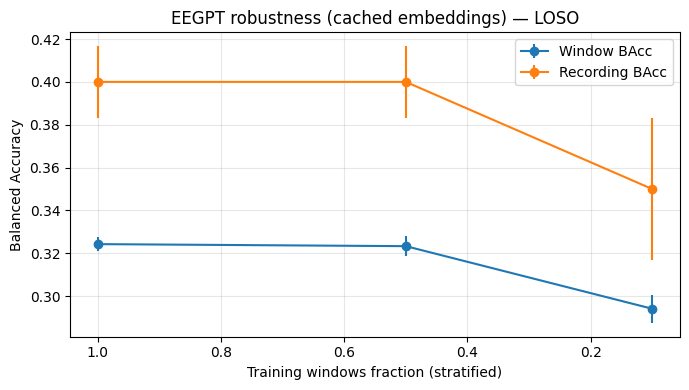

,frac,win_bacc_mean,win_bacc_std,rec_bacc_mean,rec_bacc_std
0,0.1,0.294139,0.006587,0.35,0.033333
1,0.5,0.323352,0.004809,0.40,0.016667
2,1.0,0.324304,0.003163,0.40,0.016667


In [ ]:
ROBUST_FRACS = [1.0, 0.5, 0.1]
ROBUST_SEEDS = [0,1,2,3,4]


dfs = []
for frac in ROBUST_FRACS:
    for seed in ROBUST_SEEDS:
        dfs.append(run_eegpt_robust_cached(fold_cache, frac=frac, seed=seed, num_classes=num_classes,
                                           max_epochs=120, patience=12, tau=1.0))

robust_df = pd.concat(dfs, ignore_index=True)
display(robust_df)

robust_df.to_csv("robustness_eegpt_4class_cached.csv", index=False)
print("Saved: robustness_eegpt_4class_cached.csv")

# plot (GLOBAL)
g = robust_df[robust_df["test_subject"] == "GLOBAL"].copy()
summary = g.groupby("frac").agg(
    win_bacc_mean=("win_bacc", "mean"),
    win_bacc_std =("win_bacc", "std"),
    rec_bacc_mean=("rec_bacc", "mean"),
    rec_bacc_std =("rec_bacc", "std"),
).reset_index()

plt.figure(figsize=(7,4))
plt.errorbar(summary["frac"], summary["win_bacc_mean"], yerr=summary["win_bacc_std"], marker="o", label="Window BAcc")
plt.errorbar(summary["frac"], summary["rec_bacc_mean"], yerr=summary["rec_bacc_std"], marker="o", label="Recording BAcc")
plt.gca().invert_xaxis()
plt.xlabel("Training windows fraction (stratified)")
plt.ylabel("Balanced Accuracy")
plt.title("EEGPT robustness (cached embeddings) — LOSO")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

display(summary)


# FDA

## A) Helper: estrarre finestre e rec_id dal Dataset (senza torch siccome non supportato da FDA)

In [ ]:
import numpy as np

def get_numpy_from_ds(ds):
    """
    ds: WindowDataset
    returns:
      X: (Nwin, C, T) float32
      y: (Nwin,) int64
      rec: (Nwin,) array dtype object/str
    """
    X = ds.X.astype(np.float32)
    y = ds.y.astype(np.int64)
    rec = np.asarray(ds.r)
    return X, y, rec


## B) Pooling per recording (uguale al tuo TSN pooling, ma numpy)

In [ ]:
def pool_by_recording(X_feat, y_win, rec_ids, agg="mean"):
    """
    X_feat: (Nwin, p)
    y_win : (Nwin,)
    rec_ids: (Nwin,) strings or objects
    returns:
      X_rec: (Nrec, p)
      y_rec: (Nrec,)
      rec_uniq: (Nrec,)
    """
    rec_ids = np.asarray(rec_ids).astype(str)
    uniq = np.unique(rec_ids)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec_ids == rid)
        if agg == "mean":
            Xr.append(X_feat[m].mean(axis=0))
        elif agg == "median":
            Xr.append(np.median(X_feat[m], axis=0))
        else:
            raise ValueError("agg must be mean or median")
        Yr.append(int(y_win[m][0]))
    return np.stack(Xr, axis=0), np.asarray(Yr, dtype=np.int64), uniq


## C) FDA baseline = “curve features” + PCA
Qui scegliamo due varianti:
1) PCA per-canale

    input: finestre (Nwin, 8, 1024)

    per ogni canale k: PCA su (Nwin, 1024)

    prendi K score

    concateni ⇒ (Nwin, 8K)
2) PCA globale

    appiattisci window → (Nwin, 8*1024)

    PCA globale, prendi K ⇒ (Nwin, K)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def make_fda_features_per_channel(Xtr, Xva, Xte, K=8, center=True):
    """
    X*: (Nwin, C, T)
    returns features:
      Ftr: (Nwin_tr, C*K)
      Fva: (Nwin_va, C*K)
      Fte: (Nwin_te, C*K)
    """
    C, T = Xtr.shape[1], Xtr.shape[2]
    Ftr_list, Fva_list, Fte_list = [], [], []
    pca_list = []
    for k in range(C):
        Ytr = Xtr[:, k, :]  # (Ntr, T)
        Yva = Xva[:, k, :]
        Yte = Xte[:, k, :]

        # opzionale: centra (PCA con center=True già lo fa)
        pca = PCA(n_components=K, random_state=0)
        pca.fit(Ytr)  # FIT SOLO SU TRAIN
        pca_list.append(pca)

        Ftr_list.append(pca.transform(Ytr))
        Fva_list.append(pca.transform(Yva))
        Fte_list.append(pca.transform(Yte))

    Ftr = np.concatenate(Ftr_list, axis=1)
    Fva = np.concatenate(Fva_list, axis=1)
    Fte = np.concatenate(Fte_list, axis=1)
    return Ftr.astype(np.float32), Fva.astype(np.float32), Fte.astype(np.float32), pca_list

def make_fda_features_global(Xtr, Xva, Xte, K=32):
    """
    Flatten (C,T)->(C*T) then PCA on train
    """
    Ntr, C, T = Xtr.shape
    Ztr = Xtr.reshape(Ntr, C*T)
    Zva = Xva.reshape(Xva.shape[0], C*T)
    Zte = Xte.reshape(Xte.shape[0], C*T)

    pca = PCA(n_components=K, random_state=0)
    pca.fit(Ztr)  # FIT SOLO SU TRAIN

    Ftr = pca.transform(Ztr).astype(np.float32)
    Fva = pca.transform(Zva).astype(np.float32)
    Fte = pca.transform(Zte).astype(np.float32)
    return Ftr, Fva, Fte, pca


## LOSO

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def make_fda_features_global_zpca(Xtr_raw, Xva_raw, Xte_raw, K=80):
    """
    Global FDA features:
    - z-score per canale (fit su TRAIN)
    - concatena tutti i canali
    - PCA globale (fit su TRAIN)

    Input:
      X*_raw: (Nwin, C, T)
    Output:
      G*_w:   (Nwin, K)
      pca:    PCA object
    """
    Xtr_raw = np.asarray(Xtr_raw)
    Xva_raw = np.asarray(Xva_raw)
    Xte_raw = np.asarray(Xte_raw)

    Ntr, C, T = Xtr_raw.shape

    # ------------------------------------------------
    # 1) Z-score per canale (fit su TRAIN)
    # ------------------------------------------------
    Xtr_z = np.zeros_like(Xtr_raw)
    Xva_z = np.zeros_like(Xva_raw)
    Xte_z = np.zeros_like(Xte_raw)

    scalers = []
    for c in range(C):
        sc = StandardScaler()
        Xtr_z[:, c, :] = sc.fit_transform(Xtr_raw[:, c, :])
        Xva_z[:, c, :] = sc.transform(Xva_raw[:, c, :])
        Xte_z[:, c, :] = sc.transform(Xte_raw[:, c, :])
        scalers.append(sc)

    # ------------------------------------------------
    # 2) Flatten canali + tempo
    # ------------------------------------------------
    Xtr_flat = Xtr_z.reshape(len(Xtr_z), -1)  # (Ntr, C*T)
    Xva_flat = Xva_z.reshape(len(Xva_z), -1)
    Xte_flat = Xte_z.reshape(len(Xte_z), -1)

    # ------------------------------------------------
    # 3) PCA globale (fit su TRAIN)
    # ------------------------------------------------
    pca = PCA(n_components=K, random_state=0)
    Gtr_w = pca.fit_transform(Xtr_flat)
    Gva_w = pca.transform(Xva_flat)
    Gte_w = pca.transform(Xte_flat)

    return Gtr_w, Gva_w, Gte_w, pca


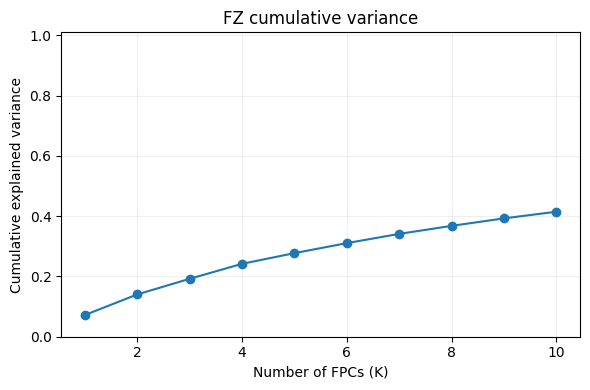

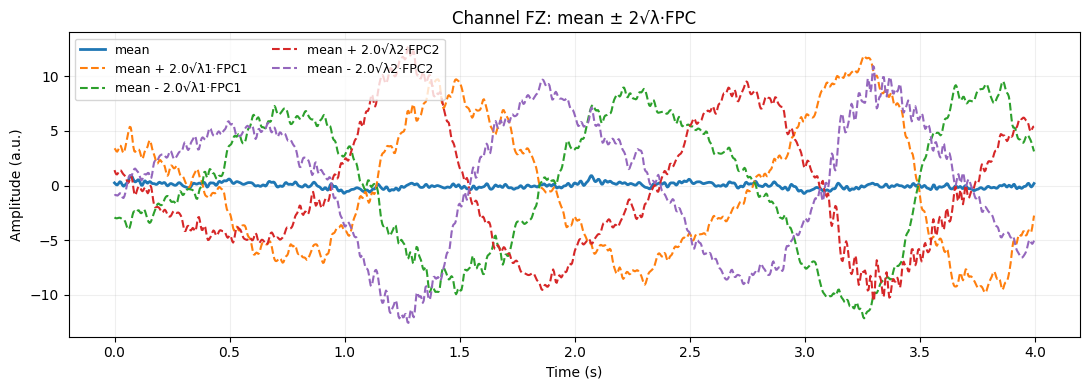

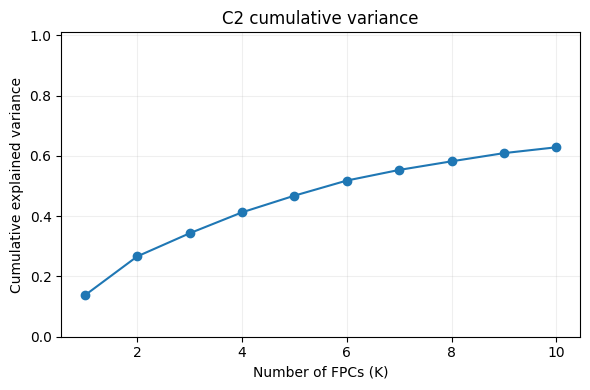

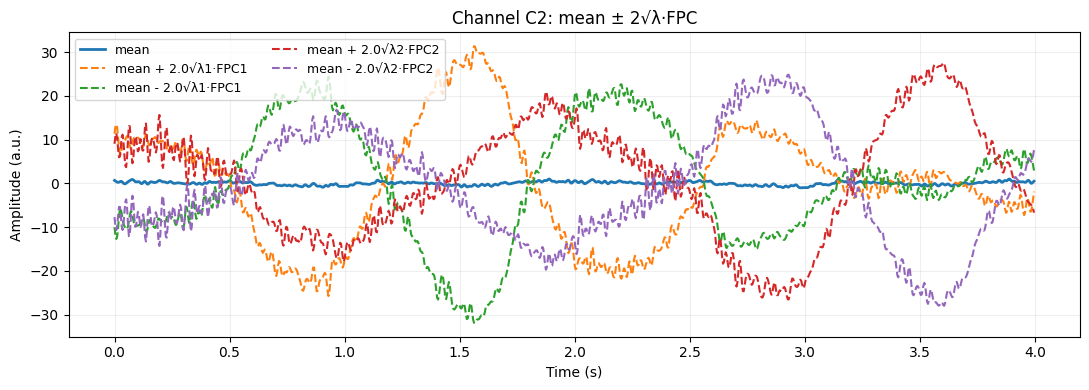


LOSO FDA per-channel (K_ch=10) — RECORDING (log-mean pooled logits)
Confusion matrix:
 [[7 1 1 6]
 [3 1 6 5]
 [3 5 3 4]
 [5 2 1 7]]
              precision    recall  f1-score   support

           0      0.389     0.467     0.424        15
           1      0.111     0.067     0.083        15
           2      0.273     0.200     0.231        15
           3      0.318     0.467     0.378        15

    accuracy                          0.300        60
   macro avg      0.273     0.300     0.279        60
weighted avg      0.273     0.300     0.279        60

Balanced Accuracy: 0.30000000000000004
Accuracy: 0.3

LOSO FDA per-channel (K_ch=10) — WINDOW
Confusion matrix:
 [[283 175 159 218]
 [131  98 116 137]
 [101 106 120 132]
 [175 151 142 276]]
              precision    recall  f1-score   support

           0      0.410     0.339     0.371       835
           1      0.185     0.203     0.194       482
           2      0.223     0.261     0.241       459
           3      0.362  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.optim as optim

# -------------------------
# Plot utils (keep as you wrote)
# -------------------------
def plot_fpcs_for_channel(pca, fs=256, n_fpc=2, alpha=2.0, title=""):
    mean = pca.mean_
    comps = pca.components_
    lam = pca.explained_variance_
    T = mean.shape[0]
    t = np.arange(T) / fs

    plt.figure(figsize=(11, 4))
    plt.plot(t, mean, linewidth=2, label="mean")

    for j in range(n_fpc):
        phi = comps[j]
        amp = alpha * np.sqrt(lam[j])
        plt.plot(t, mean + amp*phi, linestyle="--", label=f"mean + {alpha}√λ{j+1}·FPC{j+1}")
        plt.plot(t, mean - amp*phi, linestyle="--", label=f"mean - {alpha}√λ{j+1}·FPC{j+1}")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title if title else "FPC shapes")
    plt.grid(alpha=0.2)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca, title=""):
    cum = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.ylim(0, 1.01)
    plt.xlabel("Number of FPCs (K)")
    plt.ylabel("Cumulative explained variance")
    plt.title(title if title else "Cumulative variance")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# -------------------------
# t-SNE utils
# -------------------------
def tsne_sweep(X_np, y_np, title_prefix, perplexities=(5,8,10,12,15), seeds=(0,1,2), pca_dim=30):
    X_np = np.asarray(X_np)
    y_np = np.asarray(y_np).astype(int).reshape(-1)
    assert len(X_np) == len(y_np)

    Xz = StandardScaler().fit_transform(X_np)
    k = min(pca_dim, Xz.shape[1])
    Xp = PCA(n_components=k, random_state=0).fit_transform(Xz)

    for perp in perplexities:
        if perp >= (len(Xp) - 1) / 3:
            continue
        for seed in seeds:
            X2 = TSNE(
                n_components=2,
                perplexity=perp,
                init="pca",
                learning_rate="auto",
                random_state=seed
            ).fit_transform(Xp)

            plt.figure(figsize=(7, 6))
            sc = plt.scatter(X2[:, 0], X2[:, 1], c=y_np, s=55, alpha=0.85)
            plt.colorbar(sc, label="Class")
            plt.title(f"{title_prefix} | perp={perp} | seed={seed}")
            plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
            plt.tight_layout()
            plt.show()

def pool_features_by_recording_np(X_feat, y_win, rec_ids):
    """
    Per VISUALIZZAZIONE: mean-pool delle feature per recording.
    X_feat: (Nwin, D)
    y_win:  (Nwin,)
    rec_ids:(Nwin,) str
    """
    X_feat = np.asarray(X_feat)
    y_win = np.asarray(y_win).astype(int).reshape(-1)
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)

    uniq = np.unique(rec_ids)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec_ids == rid)
        Xr.append(X_feat[m].mean(axis=0))
        Yr.append(int(y_win[m][0]))  # assume label costante per recording
    return np.stack(Xr, 0), np.asarray(Yr, dtype=int), uniq

# -------------------------
# Minimal dataset for FDA (numpy-based)
# -------------------------
from torch.utils.data import Dataset

class WindowDatasetFDA(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        rec_id_all = np.asarray(rec_id_all).astype(str).reshape(-1)
        mask = np.isin(rec_id_all, list(keep_rec_set))
        self.X = np.asarray(X_all)[mask]
        self.y = np.asarray(y_all)[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i], self.r[i]

def get_numpy_from_ds(ds):
    # Assumes ds.X is (Nwin, 8, 1024), ds.y (Nwin,), ds.r (Nwin,)
    return np.asarray(ds.X), np.asarray(ds.y).astype(int), np.asarray(ds.r).astype(str)

# -------------------------
# ONE training on windows (imbalance-aware) returning TEST logits + preds
# -------------------------
def train_one_mlp_windows_return_logits(
    Xtr_w, ytr_w,
    Xva_w, yva_w,
    Xte_w, yte_w,
    num_classes,
    device,
    max_epochs=300, patience=30, lr=1e-3, wd=1e-4, tau=1.0
):
    # scale (fit train only)
    scaler = StandardScaler()
    Xtr_np = scaler.fit_transform(Xtr_w)
    Xva_np = scaler.transform(Xva_w)
    Xte_np = scaler.transform(Xte_w)

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32, device=device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32, device=device)
    Xte = torch.tensor(Xte_np, dtype=torch.float32, device=device)
    ytr = torch.tensor(ytr_w, dtype=torch.long, device=device)
    yva = torch.tensor(yva_w, dtype=torch.long, device=device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)

    # imbalance-aware loss (same as EEGPT)
    counts = np.bincount(np.asarray(ytr_w).astype(int), minlength=num_classes)
    crit = LogitAdjustedCE(counts, tau=tau).to(device)
    opt  = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def val_balacc():
        clf.eval()
        pred = clf(Xva).argmax(1).detach().cpu().numpy()
        return balanced_accuracy_score(np.asarray(yva_w).astype(int), pred)

    best, best_state, noimp = -1, None, 0
    for _ in range(max_epochs):
        clf.train()
        opt.zero_grad(set_to_none=True)
        loss = crit(clf(Xtr), ytr)
        loss.backward()
        opt.step()

        va = val_balacc()
        if va > best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1
            if noimp >= patience:
                break

    if best_state is not None:
        clf.load_state_dict(best_state)

    with torch.no_grad():
        clf.eval()
        logits_te = clf(Xte).detach().cpu().numpy()  # (Nwin_te, C)
        pred_te = logits_te.argmax(axis=1)

    return pred_te, logits_te

# ============================================================
# 0) Window-level source of truth
# ============================================================
X_win_all = X_all
y_win_all = y_all
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

assert X_win_all.shape[0] == len(y_win_all) == len(rec_id_win) == len(subj_win), \
    "Mismatch: assicurati che X_all/y_all/meta siano window-level!"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = int(np.max(y_win_all) + 1)

# recordings and subjects (recording->subject from rec_id string as you did)
rec_ids = np.unique(rec_id_win)
rec_subjects = np.array([rid.split("|")[-1] for rid in rec_ids])
subjects = np.unique(rec_subjects)

# ============================================================
# 1) LOSO loop FDA: per-channel + global
#    SINGLE TRAINING per fold (windows) + recording pooling logits
# ============================================================
K_ch   = 10
K_glob = 80

# per-channel
all_true_ch_rec, all_pred_ch_rec = [], []
all_true_ch_win, all_pred_ch_win = [], []

# global
all_true_g_rec,  all_pred_g_rec  = [], []
all_true_g_win,  all_pred_g_win  = [], []

# ==========================================================
# t-SNE config + caches (visualization only)
# ==========================================================
DO_TSNE = False
TSNE_USE_SCALED = True          # consigliato
MAX_WIN_TSNE_PER_SUBJ = 700     # limita punti per soggetto (window)
MAX_REC_TSNE_TOTAL = 1500       # limita punti globali (recording)

# per-channel tSNE caches (TEST)
all_Xte_ch_win_tsne, all_yte_ch_win_tsne = [], []
all_Xte_ch_rec_tsne, all_yte_ch_rec_tsne = [], []

# global tSNE caches (TEST)
all_Xte_g_win_tsne,  all_yte_g_win_tsne  = [], []
all_Xte_g_rec_tsne,  all_yte_g_rec_tsne  = [], []

for s in subjects:
    # --- split recording-level: test subject s
    test_rec = set(rec_ids[rec_subjects == s])
    trainval_rec = rec_ids[rec_subjects != s]
    trainval_subjects = rec_subjects[rec_subjects != s]

    # --- train/val split within trainval (group by subject)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subjects))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # --- datasets window-level
    train_ds = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, train_rec)
    val_ds   = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, val_rec)
    test_ds  = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, test_rec)

    # --- numpy windows
    Xtr_raw, ytr_w, rtr = get_numpy_from_ds(train_ds)
    Xva_raw, yva_w, rva = get_numpy_from_ds(val_ds)
    Xte_raw, yte_w, rte = get_numpy_from_ds(test_ds)

    # ==========================================================
    # (A) FDA per-channel features
    # ==========================================================
    Ftr_w, Fva_w, Fte_w, pca_list = make_fda_features_per_channel(Xtr_raw, Xva_raw, Xte_raw, K=K_ch)

    # --- ONE TRAINING (windows) -> window preds + logits
    pred_ch_win, logits_ch_win = train_one_mlp_windows_return_logits(
        Ftr_w, ytr_w, Fva_w, yva_w, Fte_w, yte_w,
        num_classes=num_classes, device=device, tau=1.0
    )

    # window-level accumulation
    all_true_ch_win.extend(yte_w.tolist())
    all_pred_ch_win.extend(pred_ch_win.tolist())

    # recording-level via log-mean pooling of WINDOW logits (NO retrain)
    rec_list_ch, pred_ch_rec, _ = recording_pool_logmean_from_logits(logits_ch_win, rte)
    true_ch_rec = recording_true_from_windows(yte_w, rte, rec_list_ch)

    all_true_ch_rec.extend(true_ch_rec.tolist())
    all_pred_ch_rec.extend(pred_ch_rec.tolist())

    # ---- t-SNE cache (per-channel FDA) - TEST only
    if DO_TSNE:
        if TSNE_USE_SCALED:
            sc = StandardScaler()
            Ftr_z = sc.fit_transform(Ftr_w)
            Fte_z = sc.transform(Fte_w)
            Xte_for_tsne = Fte_z
        else:
            Xte_for_tsne = Fte_w

        # window-level: subsample per soggetto
        Xw = Xte_for_tsne
        yw = yte_w
        if len(Xw) > MAX_WIN_TSNE_PER_SUBJ:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(Xw), size=MAX_WIN_TSNE_PER_SUBJ, replace=False)
            Xw = Xw[idx]
            yw = yw[idx]
        all_Xte_ch_win_tsne.append(Xw)
        all_yte_ch_win_tsne.append(yw)

        # recording-level: mean-pool feature per rec (solo viz)
        Xr, Yr, _ = pool_features_by_recording_np(Xte_for_tsne, yte_w, rte)
        all_Xte_ch_rec_tsne.append(Xr)
        all_yte_ch_rec_tsne.append(Yr)

    # optional FPC plots for first subject
    if s == subjects[0]:
        channel_names = ["FP1","FP2","F7","F3","FZ","F4","F8","C2"]
        for ch_idx in [4, 7]:  # FZ e C2
            plot_explained_variance(pca_list[ch_idx], title=f"{channel_names[ch_idx]} cumulative variance")
            plot_fpcs_for_channel(
                pca_list[ch_idx],
                fs=256,
                n_fpc=2,
                alpha=2.0,
                title=f"Channel {channel_names[ch_idx]}: mean ± 2√λ·FPC"
            )

    # ==========================================================
    # (B) FDA global features
    # ==========================================================
    Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global_zpca(Xtr_raw, Xva_raw, Xte_raw, K=K_glob)

    pred_g_win, logits_g_win = train_one_mlp_windows_return_logits(
        Gtr_w, ytr_w, Gva_w, yva_w, Gte_w, yte_w,
        num_classes=num_classes, device=device, tau=1.0
    )

    # window-level accumulation
    all_true_g_win.extend(yte_w.tolist())
    all_pred_g_win.extend(pred_g_win.tolist())

    # recording-level via log-mean pooling of WINDOW logits (NO retrain)
    rec_list_g, pred_g_rec, _ = recording_pool_logmean_from_logits(logits_g_win, rte)
    true_g_rec = recording_true_from_windows(yte_w, rte, rec_list_g)

    all_true_g_rec.extend(true_g_rec.tolist())
    all_pred_g_rec.extend(pred_g_rec.tolist())

    # ---- t-SNE cache (global FDA) - TEST only
    if DO_TSNE:
        if TSNE_USE_SCALED:
            sc = StandardScaler()
            Gtr_z = sc.fit_transform(Gtr_w)
            Gte_z = sc.transform(Gte_w)
            Xte_for_tsne = Gte_z
        else:
            Xte_for_tsne = Gte_w

        # window-level: subsample per soggetto
        Xw = Xte_for_tsne
        yw = yte_w
        if len(Xw) > MAX_WIN_TSNE_PER_SUBJ:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(Xw), size=MAX_WIN_TSNE_PER_SUBJ, replace=False)
            Xw = Xw[idx]
            yw = yw[idx]
        all_Xte_g_win_tsne.append(Xw)
        all_yte_g_win_tsne.append(yw)

        # recording-level: mean-pool feature per rec (solo viz)
        Xr, Yr, _ = pool_features_by_recording_np(Xte_for_tsne, yte_w, rte)
        all_Xte_g_rec_tsne.append(Xr)
        all_yte_g_rec_tsne.append(Yr)

# ============================================================
# 2) Final reports
# ============================================================

print("\n==============================")
print(f"LOSO FDA per-channel (K_ch={K_ch}) — RECORDING (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true_ch_rec, all_pred_ch_rec)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_ch_rec, all_pred_ch_rec, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_ch_rec, all_pred_ch_rec))
print("Accuracy:", accuracy_score(all_true_ch_rec, all_pred_ch_rec))

print("\n==============================")
print(f"LOSO FDA per-channel (K_ch={K_ch}) — WINDOW")
print("==============================")
cm = confusion_matrix(all_true_ch_win, all_pred_ch_win)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_ch_win, all_pred_ch_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_ch_win, all_pred_ch_win))
print("Accuracy:", accuracy_score(all_true_ch_win, all_pred_ch_win))

print("\n==============================")
print(f"LOSO FDA global (K_glob={K_glob}) — RECORDING (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true_g_rec, all_pred_g_rec)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_g_rec, all_pred_g_rec, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_g_rec, all_pred_g_rec))
print("Accuracy:", accuracy_score(all_true_g_rec, all_pred_g_rec))

print("\n==============================")
print(f"LOSO FDA global (K_glob={K_glob}) — WINDOW")
print("==============================")
cm = confusion_matrix(all_true_g_win, all_pred_g_win)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_g_win, all_pred_g_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_g_win, all_pred_g_win))
print("Accuracy:", accuracy_score(all_true_g_win, all_pred_g_win))

# sanity prints
print("X_all:", np.shape(X_all))
print("y_all:", np.shape(y_all))
print('meta["rec_id"]:', np.shape(meta["rec_id"]))
print('meta["subject"]:', np.shape(meta["subject"]))

# ============================================================
# 3) FINAL t-SNE plots (optional)
# ============================================================
if DO_TSNE:
    # ---- PER-CHANNEL ----
    if len(all_Xte_ch_rec_tsne) > 0:
        Xrec = np.concatenate(all_Xte_ch_rec_tsne, axis=0)
        yrec = np.concatenate(all_yte_ch_rec_tsne, axis=0)

        if len(Xrec) > MAX_REC_TSNE_TOTAL:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(Xrec), size=MAX_REC_TSNE_TOTAL, replace=False)
            Xrec, yrec = Xrec[idx], yrec[idx]

        if len(Xrec) >= 10:
            tsne_sweep(
                Xrec, yrec,
                title_prefix=f"FDA per-channel t-SNE (RECORDING mean-pooled, TEST) | K_ch={K_ch}",
                perplexities=(5, 8, 10, 12, 15),
                seeds=(0, 1, 2),
                pca_dim=30
            )

    if len(all_Xte_ch_win_tsne) > 0:
        Xwin = np.concatenate(all_Xte_ch_win_tsne, axis=0)
        ywin = np.concatenate(all_yte_ch_win_tsne, axis=0)

        if len(Xwin) >= 50:
            tsne_sweep(
                Xwin, ywin,
                title_prefix=f"FDA per-channel t-SNE (WINDOWS, TEST) | K_ch={K_ch}",
                perplexities=(10, 15, 20, 30, 40),
                seeds=(0, 1, 2),
                pca_dim=30
            )

    # ---- GLOBAL ----
    if len(all_Xte_g_rec_tsne) > 0:
        Xrec = np.concatenate(all_Xte_g_rec_tsne, axis=0)
        yrec = np.concatenate(all_yte_g_rec_tsne, axis=0)

        if len(Xrec) > MAX_REC_TSNE_TOTAL:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(Xrec), size=MAX_REC_TSNE_TOTAL, replace=False)
            Xrec, yrec = Xrec[idx], yrec[idx]

        if len(Xrec) >= 10:
            tsne_sweep(
                Xrec, yrec,
                title_prefix=f"FDA global t-SNE (RECORDING mean-pooled, TEST) | K_glob={K_glob}",
                perplexities=(5, 8, 10, 12, 15),
                seeds=(0, 1, 2),
                pca_dim=30
            )

    if len(all_Xte_g_win_tsne) > 0:
        Xwin = np.concatenate(all_Xte_g_win_tsne, axis=0)
        ywin = np.concatenate(all_yte_g_win_tsne, axis=0)

        if len(Xwin) >= 50:
            tsne_sweep(
                Xwin, ywin,
                title_prefix=f"FDA global t-SNE (WINDOWS, TEST) | K_glob={K_glob}",
                perplexities=(10, 15, 20, 30, 40),
                seeds=(0, 1, 2),
                pca_dim=30
            )


## D)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def recording_pool_logmean_logits(logits_np, rec_ids):
    """
    logits_np: (Nwin, C) logits (numpy)
    rec_ids:   (Nwin,) rec_id (str)
    Returns:
      rec_list: (Nrec,) unique rec ids
      rec_logmean: (Nrec, C) mean(log_softmax(logits)) per recording
    """
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)
    logits_np = np.asarray(logits_np)

    uniq = np.unique(rec_ids)
    out = []
    for rid in uniq:
        m = (rec_ids == rid)
        L = torch.tensor(logits_np[m], dtype=torch.float32)  # (m,C)
        logp = F.log_softmax(L, dim=1)
        out.append(logp.mean(dim=0))
    rec_logmean = torch.stack(out, dim=0).cpu().numpy()
    return uniq, rec_logmean

def logit_margin_from_logits(logits_or_logp):
    """
    logits_or_logp: (N,C)
    margin = top1 - top2
    """
    A = np.asarray(logits_or_logp)
    part = np.partition(A, kth=-2, axis=1)
    top2 = part[:, -2]
    top1 = part[:, -1]
    return top1 - top2


## E)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

# ---- config interpretazione
K_glob_int = K_glob  # usa lo stesso K del tuo benchmark (es. 80 per 3-class, 160 per 2-class)
DO_SCATTER_TOP = 3   # quanti scatter plottare

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sorgente dati
X_win_all  = X_all
y_win_all  = y_all
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

num_classes = int(np.max(y_win_all) + 1)

# define subjects come nel tuo EEGPT block (NOTA: qui uso meta["subject"] direttamente)
subjects = np.unique(subj_win)

# ---- accumulators: per recording
all_scores_fda = []      # (Nrec, K)
all_margin_eegpt = []    # (Nrec,)
all_prob_eegpt = []      # (Nrec, C) opzionale
all_y_rec = []           # (Nrec,)
all_rec_ids = []         # (Nrec,)

# Map recording -> subject (prima finestra)
uniq_rec = np.unique(rec_id_win)
rec_to_subj = {}
for rid in uniq_rec:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_to_subj[rid] = subj_win[idx0]

for s_test in subjects:
    # split recording-level: test subject s
    test_rec = set(np.unique(rec_id_win[subj_win == s_test]))
    trainval_rec = np.unique(rec_id_win[subj_win != s_test])
    trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # datasets
    train_ds = WindowDataset(X_win_all, y_win_all, rec_id_win, train_rec)
    val_ds   = WindowDataset(X_win_all, y_win_all, rec_id_win, val_rec)
    test_ds  = WindowDataset(X_win_all, y_win_all, rec_id_win, test_rec)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    # ========== EEGPT pipeline (embeddings + downstream) ==========
    tr_feat, tr_y, tr_r = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_r = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_r = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    Xtr = to_np(tr_feat); ytr = to_np(tr_y).astype(int)
    Xva = to_np(va_feat); yva = to_np(va_y).astype(int)
    Xte = to_np(te_feat); yte = to_np(te_y).astype(int)

    # scale
    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr)
    Xva = sc.transform(Xva)
    Xte = sc.transform(Xte)

    # train downstream MLP (come fai tu)
    clf = train_mlp_with_val(Xtr, ytr, Xva, yva, num_classes=num_classes, device=device, tau=1.0)

    # logits window-level sul test
    with torch.no_grad():
        clf.eval()
        logits_te = clf(torch.tensor(Xte, dtype=torch.float32).to(device)).detach().cpu().numpy()  # (Nwin_te,C)

    # pooling logits -> recording log-mean (in log-prob space)
    rec_list, rec_logmean = recording_pool_logmean_logits(logits_te, np.asarray(te_r).astype(str))
    y_rec = recording_true_from_windows(yte, np.asarray(te_r).astype(str), rec_list)

    # decision signal (margin)
    margin = logit_margin_from_logits(rec_logmean)  # (Nrec,)

    # also pooled probs if you want (softmax of log-mean logp)
    prob = np.exp(rec_logmean)
    prob = prob / prob.sum(axis=1, keepdims=True)  # numeric safe

    # ========== FDA GLOBAL scores sullo STESSO fold ==========
    # recupero raw windows per FDA (da X_all originale, non embeddings)
    # NB: WindowDataset restituisce torch, qui invece vuoi raw numpy -> facciamolo direttamente da mask
    # usando rec_id_win che hai già
    def select_by_rec_set(rec_set):
        m = np.isin(np.asarray(rec_id_win).astype(str), list(rec_set))
        return np.asarray(X_win_all)[m], np.asarray(y_win_all)[m].astype(int), np.asarray(rec_id_win)[m].astype(str)

    Xtr_raw, _, _ = select_by_rec_set(train_rec)
    Xva_raw, _, _ = select_by_rec_set(val_rec)
    Xte_raw, _, _ = select_by_rec_set(test_rec)

    # FDA global (questa funzione deve già esistere nel tuo notebook)
    Gtr_w, Gva_w, Gte_w, pca_glob = make_fda_features_global_zpca(Xtr_raw, Xva_raw, Xte_raw, K=K_glob_int)

    # Ora: vogliamo score recording-level (mean per rec) sugli score window-level.
    # Ma make_fda_features_global_zpca tipicamente restituisce già i "scores" window-level come feature.
    # Quindi per recording scores facciamo mean-pool delle feature per rec:
    # Attenzione: dobbiamo allinearli con rec_list (uniques su test)
    # costruiamo dict rec -> mean(feature)
    rte = select_by_rec_set(test_rec)[2]  # rec_id per ogni finestra test, stesso ordine di Xte_raw
    rte = np.asarray(rte).astype(str)

    scores_rec = []
    for rid in rec_list:
        mm = (rte == rid)
        scores_rec.append(Gte_w[mm].mean(axis=0))
    scores_rec = np.vstack(scores_rec)  # (Nrec, K_glob)

    # accumulate
    all_scores_fda.append(scores_rec)
    all_margin_eegpt.append(margin)
    all_prob_eegpt.append(prob)
    all_y_rec.append(y_rec)
    all_rec_ids.append(rec_list)

# stack all folds
S = np.vstack(all_scores_fda)                 # (Nrec_total, K)
M = np.concatenate(all_margin_eegpt)          # (Nrec_total,)
P = np.vstack(all_prob_eegpt)                # (Nrec_total, C)
Y = np.concatenate(all_y_rec)                # (Nrec_total,)
R = np.concatenate(all_rec_ids).astype(str)  # (Nrec_total,)

print("Shapes:")
print("scores FDA:", S.shape, "| margin:", M.shape, "| probs:", P.shape, "| y:", Y.shape)


Shapes:
scores FDA: (60, 80) | margin: (60,) | probs: (60, 4) | y: (60,)


## F)

In [ ]:
# Spearman corr tra score_k e margin
corr_margin = np.zeros(S.shape[1])
pval_margin = np.zeros(S.shape[1])
for k in range(S.shape[1]):
    rho, pv = spearmanr(S[:, k], M)
    corr_margin[k] = rho
    pval_margin[k] = pv

# Spearman corr tra score_k e prob classe c
corr_prob = np.zeros((S.shape[1], P.shape[1]))
pval_prob = np.zeros((S.shape[1], P.shape[1]))
for k in range(S.shape[1]):
    for c in range(P.shape[1]):
        rho, pv = spearmanr(S[:, k], P[:, c])
        corr_prob[k, c] = rho
        pval_prob[k, c] = pv

# Top K by |rho| on margin
topk = 10
idx = np.argsort(-np.abs(corr_margin))[:topk]
print("\nTop correlations with EEGPT margin (abs):")
for rank, k in enumerate(idx, 1):
    print(f"{rank:02d}) FPC{k+1:03d}: rho={corr_margin[k]:+.3f}  p={pval_margin[k]:.2e}")



Top correlations with EEGPT margin (abs):
01) FPC077: rho=+0.237  p=6.84e-02
02) FPC070: rho=-0.236  p=7.01e-02
03) FPC021: rho=+0.232  p=7.50e-02
04) FPC019: rho=-0.217  p=9.56e-02
05) FPC050: rho=+0.212  p=1.05e-01
06) FPC029: rho=+0.204  p=1.18e-01
07) FPC039: rho=-0.199  p=1.27e-01
08) FPC018: rho=+0.196  p=1.34e-01
09) FPC048: rho=-0.195  p=1.35e-01
10) FPC062: rho=-0.195  p=1.35e-01


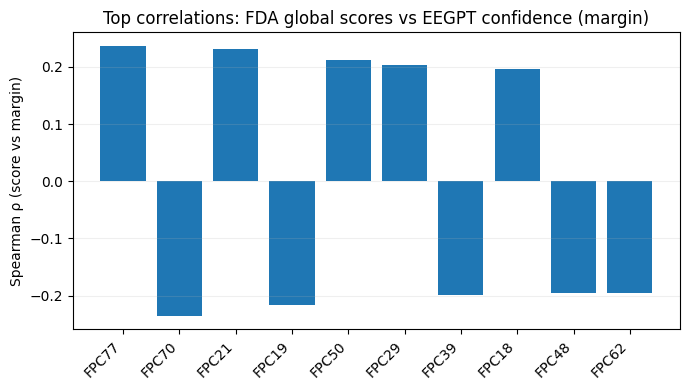

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(np.arange(topk), corr_margin[idx])
plt.xticks(np.arange(topk), [f"FPC{k+1}" for k in idx], rotation=45, ha="right")
plt.ylabel("Spearman ρ (score vs margin)")
plt.title("Top correlations: FDA global scores vs EEGPT confidence (margin)")
plt.grid(alpha=0.2, axis="y")
plt.tight_layout()
plt.show()


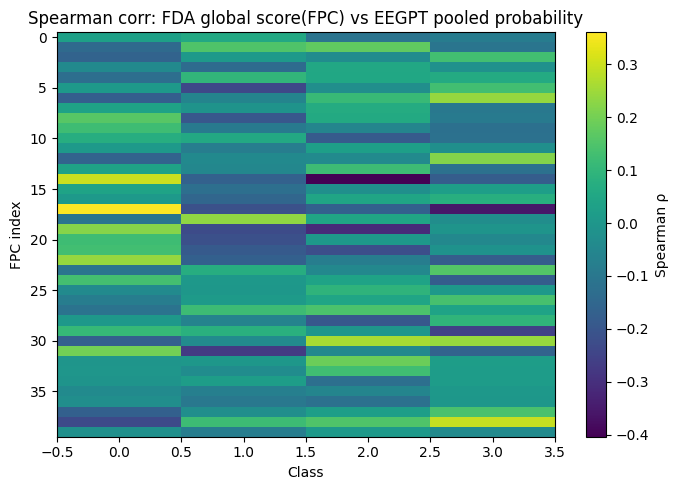

In [ ]:
K_show = min(40, corr_prob.shape[0])
plt.figure(figsize=(7,5))
plt.imshow(corr_prob[:K_show, :], aspect="auto")
plt.colorbar(label="Spearman ρ")
plt.xlabel("Class")
plt.ylabel("FPC index")
plt.title("Spearman corr: FDA global score(FPC) vs EEGPT pooled probability")
plt.tight_layout()
plt.show()


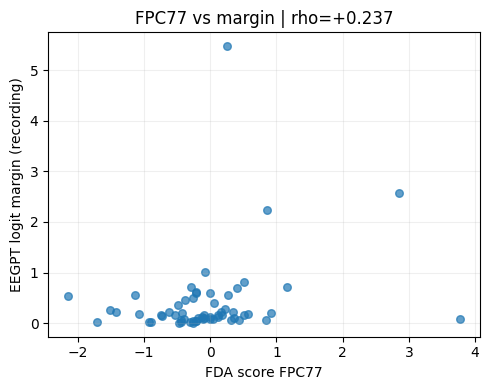

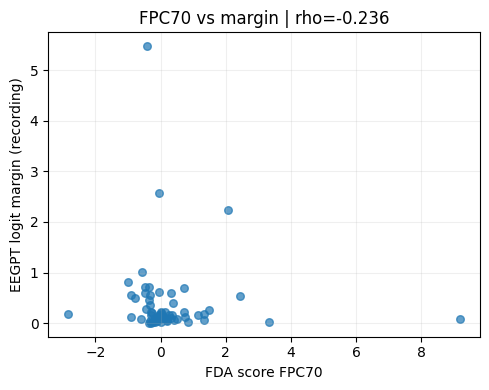

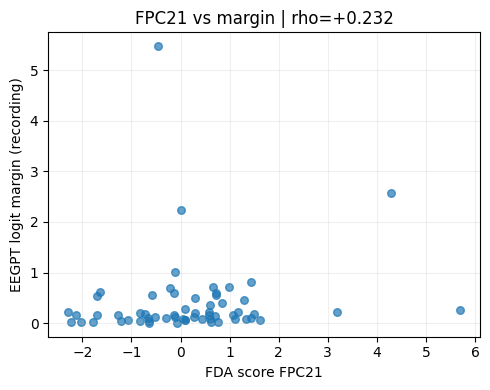

In [ ]:
for j in range(min(DO_SCATTER_TOP, len(idx))):
    k = idx[j]
    plt.figure(figsize=(5,4))
    plt.scatter(S[:, k], M, s=30, alpha=0.7)
    plt.xlabel(f"FDA score FPC{k+1}")
    plt.ylabel("EEGPT logit margin (recording)")
    plt.title(f"FPC{k+1} vs margin | rho={corr_margin[k]:+.3f}")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


## Robustness

In [ ]:
# ============================================================
# ROBUSTNESS (FDA): re-using EEGPT robustness helpers
# - Uses existing: ROBUST_FRACS, ROBUST_SEEDS,
#   stratified_subsample_indices, compute_metrics
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import GroupShuffleSplit

# usa i K già scelti sopra nel tuo notebook
K_ch_rob   = K_ch
K_glob_rob = K_glob

def run_loso_fda_robust(frac, seed, K_ch, K_glob):
    rng = np.random.RandomState(seed)

    # window-level source of truth
    X_win_all  = X_all
    y_win_all  = y_all
    rec_id_win = meta["rec_id"].astype(str)
    subj_win   = meta["subject"].astype(str)

    assert X_win_all.shape[0] == len(y_win_all) == len(rec_id_win) == len(subj_win)

    num_classes = int(np.max(y_win_all) + 1)

    # recordings & subjects come nel tuo codice (rid.split("|")[-1])
    rec_ids = np.unique(rec_id_win)
    rec_subjects = np.array([rid.split("|")[-1] for rid in rec_ids])
    subjects = np.unique(rec_subjects)

    rows = []

    # accumulators globali
    ch_true_win, ch_pred_win = [], []
    ch_true_rec, ch_pred_rec = [], []
    g_true_win,  g_pred_win  = [], []
    g_true_rec,  g_pred_rec  = [], []

    for s in subjects:
        # --- split recording-level: test subject s
        test_rec = set(rec_ids[rec_subjects == s])
        trainval_rec = rec_ids[rec_subjects != s]
        trainval_subjects = rec_subjects[rec_subjects != s]

        # --- train/val split grouped by subject
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subjects))
        train_rec = set(trainval_rec[tr_idx])
        val_rec   = set(trainval_rec[va_idx])

        # --- datasets window-level
        train_ds_full = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, train_rec)
        val_ds        = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, val_rec)
        test_ds       = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, test_rec)

        # --- subsample SOLO TRAIN windows (re-using helper)
        keep_idx = stratified_subsample_indices(train_ds_full.y, frac, rng)
        train_ds = Subset(train_ds_full, keep_idx)

        # --- numpy windows
        Xtr_raw, ytr_w, rtr = get_numpy_from_ds(train_ds)  # subsampled train
        Xva_raw, yva_w, rva = get_numpy_from_ds(val_ds)
        Xte_raw, yte_w, rte = get_numpy_from_ds(test_ds)

        # ==========================================================
        # (A) FDA per-channel
        # ==========================================================
        Ftr_w, Fva_w, Fte_w, _ = make_fda_features_per_channel(Xtr_raw, Xva_raw, Xte_raw, K=K_ch)

        pred_ch_win, logits_ch_win = train_one_mlp_windows_return_logits(
            Ftr_w, ytr_w, Fva_w, yva_w, Fte_w, yte_w,
            num_classes=num_classes, device=device, tau=1.0
        )

        ch_true_win.extend(yte_w.tolist())
        ch_pred_win.extend(pred_ch_win.tolist())

        rec_list_ch, pred_ch_rec, _ = recording_pool_logmean_from_logits(logits_ch_win, rte)
        true_ch_rec = recording_true_from_windows(yte_w, rte, rec_list_ch)

        ch_true_rec.extend(true_ch_rec.tolist())
        ch_pred_rec.extend(pred_ch_rec.tolist())

        # ==========================================================
        # (B) FDA global
        # ==========================================================
        Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global_zpca(Xtr_raw, Xva_raw, Xte_raw, K=K_glob)

        pred_g_win, logits_g_win = train_one_mlp_windows_return_logits(
            Gtr_w, ytr_w, Gva_w, yva_w, Gte_w, yte_w,
            num_classes=num_classes, device=device, tau=1.0
        )

        g_true_win.extend(yte_w.tolist())
        g_pred_win.extend(pred_g_win.tolist())

        rec_list_g, pred_g_rec, _ = recording_pool_logmean_from_logits(logits_g_win, rte)
        true_g_rec = recording_true_from_windows(yte_w, rte, rec_list_g)

        g_true_rec.extend(true_g_rec.tolist())
        g_pred_rec.extend(pred_g_rec.tolist())

        # per-subject metrics (utile per boxplot)
        m_ch_w = compute_metrics(yte_w, pred_ch_win)
        m_ch_r = compute_metrics(true_ch_rec, pred_ch_rec)
        m_g_w  = compute_metrics(yte_w, pred_g_win)
        m_g_r  = compute_metrics(true_g_rec, pred_g_rec)

        rows.append({
            "seed": seed,
            "frac": frac,
            "test_subject": s,
            "K_ch": K_ch,
            "K_glob": K_glob,

            "ch_win_bacc": m_ch_w["bacc"],
            "ch_rec_bacc": m_ch_r["bacc"],
            "g_win_bacc":  m_g_w["bacc"],
            "g_rec_bacc":  m_g_r["bacc"],
        })

    # GLOBAL row
    g_ch_w = compute_metrics(ch_true_win, ch_pred_win)
    g_ch_r = compute_metrics(ch_true_rec, ch_pred_rec)
    g_g_w  = compute_metrics(g_true_win,  g_pred_win)
    g_g_r  = compute_metrics(g_true_rec,  g_pred_rec)

    rows.append({
        "seed": seed,
        "frac": frac,
        "test_subject": "GLOBAL",
        "K_ch": K_ch,
        "K_glob": K_glob,

        "ch_win_bacc": g_ch_w["bacc"],
        "ch_rec_bacc": g_ch_r["bacc"],
        "g_win_bacc":  g_g_w["bacc"],
        "g_rec_bacc":  g_g_r["bacc"],
    })

    return pd.DataFrame(rows)



In [ ]:
# ============================================================
# BUILD FDA FOLD CACHE (RAW windows per LOSO fold)
# ============================================================

import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def build_fda_fold_cache_raw(X_all, y_all, meta):
    X_all = np.asarray(X_all)
    y_all = np.asarray(y_all).astype(int)
    rec_id = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
    subj   = np.asarray(meta["subject"]).astype(str).reshape(-1)

    subjects = np.unique(subj)

    # rec -> subj (first window)
    uniq_rec = np.unique(rec_id)
    rec_to_subj = {}
    for rid in uniq_rec:
        idx0 = np.where(rec_id == rid)[0][0]
        rec_to_subj[rid] = subj[idx0]

    cache = {}
    for s_test in subjects:
        test_rec = set(np.unique(rec_id[subj == s_test]))

        trainval_rec = np.unique(rec_id[subj != s_test])
        trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
        train_rec = set(trainval_rec[tr_idx])
        val_rec   = set(trainval_rec[va_idx])

        m_tr = np.isin(rec_id, list(train_rec))
        m_va = np.isin(rec_id, list(val_rec))
        m_te = np.isin(rec_id, list(test_rec))

        cache[s_test] = {
            "Xtr_full": X_all[m_tr],
            "ytr_full": y_all[m_tr],
            "Xva":      X_all[m_va],
            "yva":      y_all[m_va],
            "Xte":      X_all[m_te],
            "yte":      y_all[m_te],
            "te_rec":   rec_id[m_te],
        }

        print(f"[FDA cache] subj={s_test} | "
              f"train={cache[s_test]['Xtr_full'].shape[0]} "
              f"val={cache[s_test]['Xva'].shape[0]} "
              f"test={cache[s_test]['Xte'].shape[0]}")

    return cache

# ---- run once
fda_fold_cache = build_fda_fold_cache_raw(X_all, y_all, meta)
print("Done. fda_fold_cache folds:", len(fda_fold_cache))


[FDA cache] subj=S1 | train=1867 val=479 test=174
[FDA cache] subj=S10 | train=1867 val=495 test=158
[FDA cache] subj=S11 | train=1846 val=495 test=179
[FDA cache] subj=S12 | train=1859 val=495 test=166
[FDA cache] subj=S13 | train=1871 val=495 test=154
[FDA cache] subj=S14 | train=1888 val=495 test=137
[FDA cache] subj=S15 | train=1869 val=495 test=156
[FDA cache] subj=S2 | train=1800 val=495 test=225
[FDA cache] subj=S3 | train=1872 val=495 test=153
[FDA cache] subj=S4 | train=1899 val=495 test=126
[FDA cache] subj=S5 | train=1899 val=446 test=175
[FDA cache] subj=S6 | train=1929 val=446 test=145
[FDA cache] subj=S7 | train=1929 val=445 test=146
[FDA cache] subj=S8 | train=1878 val=445 test=197
[FDA cache] subj=S9 | train=1846 val=445 test=229
Done. fda_fold_cache folds: 15


,seed,frac,test_subject,n_train_full,n_train_used,ch_rec_bacc,g_rec_bacc
0,0,1.0,S1,1867.0,1867.0,0.250000,0.250000
1,0,1.0,S10,1867.0,1867.0,0.250000,0.250000
2,0,1.0,S11,1846.0,1846.0,0.250000,0.500000
3,0,1.0,S12,1859.0,1859.0,0.250000,0.250000
4,0,1.0,S13,1871.0,1871.0,0.250000,0.250000
...,...,...,...,...,...,...,...
235,4,0.1,S6,1929.0,194.0,0.250000,0.250000
236,4,0.1,S7,1929.0,194.0,0.250000,0.250000
237,4,0.1,S8,1878.0,187.0,0.250000,0.500000
238,4,0.1,S9,1846.0,184.0,0.250000,0.500000


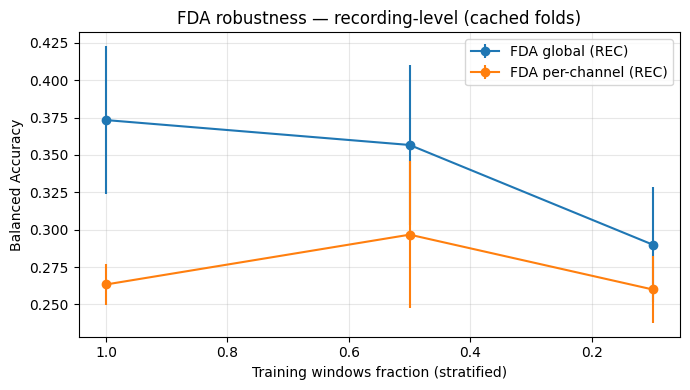

,frac,ch_rec_mean,ch_rec_std,g_rec_mean,g_rec_std
0,0.1,0.260000,0.022361,0.290000,0.038370
1,0.5,0.296667,0.049160,0.356667,0.053489
2,1.0,0.263333,0.013944,0.373333,0.049441


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def run_fda_robust_cached(fold_cache, frac, seed, K_ch, K_glob, num_classes):
    rng = np.random.RandomState(seed)

    rows = []

    # global accumulators (per-channel)
    ch_true_win, ch_pred_win = [], []
    ch_true_rec, ch_pred_rec = [], []

    # global accumulators (global)
    g_true_win,  g_pred_win  = [], []
    g_true_rec,  g_pred_rec  = [], []

    for s_test, d in fold_cache.items():
        Xtr_full = d["Xtr_full"]; ytr_full = d["ytr_full"]
        Xva      = d["Xva"];      yva      = d["yva"]
        Xte      = d["Xte"];      yte      = d["yte"]
        te_rec   = np.asarray(d["te_rec"]).astype(str)

        # subsample SOLO TRAIN windows (stratificato)
        keep_idx = stratified_subsample_indices(ytr_full, frac, rng)
        Xtr = Xtr_full[keep_idx]
        ytr = ytr_full[keep_idx]

        base_seed = 10000*seed + (abs(hash(str(s_test))) % 10000)

        # --------------------------
        # (A) FDA per-channel
        # --------------------------
        Ftr, Fva, Fte, _ = make_fda_features_per_channel(Xtr, Xva, Xte, K=K_ch)

        set_all_seeds(base_seed + 1)
        pred_ch_win_fold, logits_ch = train_one_mlp_windows_return_logits(
            Ftr, ytr, Fva, yva, Fte, yte,
            num_classes=num_classes, device=device, tau=1.0,
            max_epochs=120, patience=12
        )

        ch_true_win.extend(yte.tolist())
        ch_pred_win.extend(pred_ch_win_fold.tolist())

        rec_list, pred_ch_rec_fold, _ = recording_pool_logmean_from_logits(logits_ch, te_rec)
        true_ch_rec_fold = recording_true_from_windows(yte, te_rec, rec_list)

        ch_true_rec.extend(true_ch_rec_fold.tolist())
        ch_pred_rec.extend(pred_ch_rec_fold.tolist())

        # --------------------------
        # (B) FDA global
        # --------------------------
        Gtr, Gva, Gte, _ = make_fda_features_global_zpca(Xtr, Xva, Xte, K=K_glob)

        set_all_seeds(base_seed + 2)
        pred_g_win_fold, logits_g = train_one_mlp_windows_return_logits(
            Gtr, ytr, Gva, yva, Gte, yte,
            num_classes=num_classes, device=device, tau=1.0,
            max_epochs=120, patience=12
        )

        g_true_win.extend(yte.tolist())
        g_pred_win.extend(pred_g_win_fold.tolist())

        rec_list_g, pred_g_rec_fold, _ = recording_pool_logmean_from_logits(logits_g, te_rec)
        true_g_rec_fold = recording_true_from_windows(yte, te_rec, rec_list_g)

        g_true_rec.extend(true_g_rec_fold.tolist())
        g_pred_rec.extend(pred_g_rec_fold.tolist())

        # per-subject metrics (fold-level!)
        m_ch_r = compute_metrics(true_ch_rec_fold, pred_ch_rec_fold)
        m_g_r  = compute_metrics(true_g_rec_fold,  pred_g_rec_fold)

        rows.append({
            "seed": seed, "frac": frac, "test_subject": s_test,
            "n_train_full": len(ytr_full),
            "n_train_used": len(keep_idx),
            "ch_rec_bacc": m_ch_r["bacc"],
            "g_rec_bacc":  m_g_r["bacc"],
        })

    # GLOBAL row
    g_ch_r = compute_metrics(ch_true_rec, ch_pred_rec)
    g_g_r  = compute_metrics(g_true_rec,  g_pred_rec)

    rows.append({
        "seed": seed, "frac": frac, "test_subject": "GLOBAL",
        "n_train_full": np.nan, "n_train_used": np.nan,
        "ch_rec_bacc": g_ch_r["bacc"],
        "g_rec_bacc":  g_g_r["bacc"],
    })

    return pd.DataFrame(rows)

# ---- sweep
ROBUST_FRACS = [1.0, 0.5, 0.1]
ROBUST_SEEDS = [0,1,2,3,4]

num_classes = int(np.max(y_all) + 1)

dfs = []
for frac in ROBUST_FRACS:
    for seed in ROBUST_SEEDS:
        dfs.append(run_fda_robust_cached(
            fda_fold_cache, frac=frac, seed=seed,
            K_ch=K_ch, K_glob=K_glob,
            num_classes=num_classes
        ))

robust_fda_df = pd.concat(dfs, ignore_index=True)
display(robust_fda_df)

# ---- summary + plot (GLOBAL only)
g = robust_fda_df[robust_fda_df["test_subject"] == "GLOBAL"].copy()
summary_fda = g.groupby("frac").agg(
    ch_rec_mean=("ch_rec_bacc", "mean"),
    ch_rec_std =("ch_rec_bacc", "std"),
    g_rec_mean =("g_rec_bacc",  "mean"),
    g_rec_std  =("g_rec_bacc",  "std"),
).reset_index()

plt.figure(figsize=(7,4))
plt.errorbar(summary_fda["frac"], summary_fda["g_rec_mean"], yerr=summary_fda["g_rec_std"], marker="o", label="FDA global (REC)")
plt.errorbar(summary_fda["frac"], summary_fda["ch_rec_mean"], yerr=summary_fda["ch_rec_std"], marker="o", label="FDA per-channel (REC)")
plt.gca().invert_xaxis()
plt.xlabel("Training windows fraction (stratified)")
plt.ylabel("Balanced Accuracy")
plt.title("FDA robustness — recording-level (cached folds)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

display(summary_fda)
